In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf 
import os
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Activation, Dropout
from tensorflow import keras
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.utils import plot_model


In [3]:

!pip install efficientnet
import efficientnet.tfkeras as efn

In [4]:
AUTO = tf.data.experimental.AUTOTUNE
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [5]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


> <h3> Extracting Cataract & Normal information from the Dataset </h3>

In [28]:
def has_Diabetes (text):
    if "moderate non proliferative retinopathy" in text:
        return 1
    else:
        return 0

In [29]:
df["left_Diabetes"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_Diabetes(x))
df["right_Diabetes"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_Diabetes(x))

In [33]:
left_Diabetes = df.loc[(df.D==1) & (df.left_Diabetes == 1)]["Left-Fundus"].values
left_Diabetes[:15]

array(['2_left.jpg', '5_left.jpg', '11_left.jpg', '26_left.jpg',
       '44_left.jpg', '46_left.jpg', '47_left.jpg', '50_left.jpg',
       '72_left.jpg', '74_left.jpg', '77_left.jpg', '81_left.jpg',
       '87_left.jpg', '90_left.jpg', '93_left.jpg'], dtype=object)

In [34]:
right_Diabetes = df.loc[(df.D ==1) & (df.right_Diabetes == 1)]["Right-Fundus"].values
right_Diabetes[:15]

array(['2_right.jpg', '5_right.jpg', '6_right.jpg', '11_right.jpg',
       '26_right.jpg', '27_right.jpg', '44_right.jpg', '50_right.jpg',
       '54_right.jpg', '81_right.jpg', '89_right.jpg', '90_right.jpg',
       '93_right.jpg', '96_right.jpg', '107_right.jpg'], dtype=object)

In [35]:
print("Number of images in left cataract: {}".format(len(left_Diabetes)))
print("Number of images in right cataract: {}".format(len(right_Diabetes)))

Number of images in left cataract: 917
Number of images in right cataract: 960


>Normal Images

In [36]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(920,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(970,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [37]:
print("Number of images in left normal: {}".format(len(left_normal)))
print("Number of images in right normal: {}".format(len(right_normal)))

Number of images in left normal: 920
Number of images in right normal: 970


In [40]:
Diabetes = np.concatenate((left_Diabetes,right_Diabetes),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [42]:
print(len(Diabetes),len(normal))

1877 1890


><h3>Creating Dataset from images</h3>

In [43]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset
        

In [44]:
dataset = create_dataset(Diabetes,1)

100%|██████████| 1877/1877 [00:24<00:00, 77.53it/s] 


In [45]:
len(dataset)

1847

In [46]:
dataset = create_dataset(normal,0)

100%|██████████| 1890/1890 [00:31<00:00, 59.27it/s]


In [47]:
len(dataset)

3737

><h3>Let's see some images</h3>

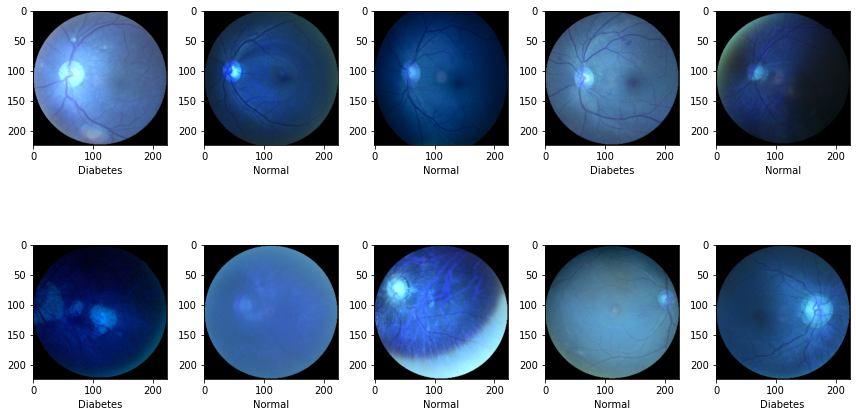

In [48]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Diabetes"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

><h3>Dividing dataset into x(features) & y(target)</h3>

In [49]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [50]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

><h3>Creating Model</h3>

In [51]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80142336/80134624 [==============================] - 1s 0us/step


In [52]:
for layer in vgg.layers:
    layer.trainable = False

In [53]:

model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(keras.layers.Dense(1024))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())

model.add(keras.layers.Dense(512))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())

model.add(keras.layers.Dense(256))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU())
model.add(Dense(1,activation="sigmoid"))

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

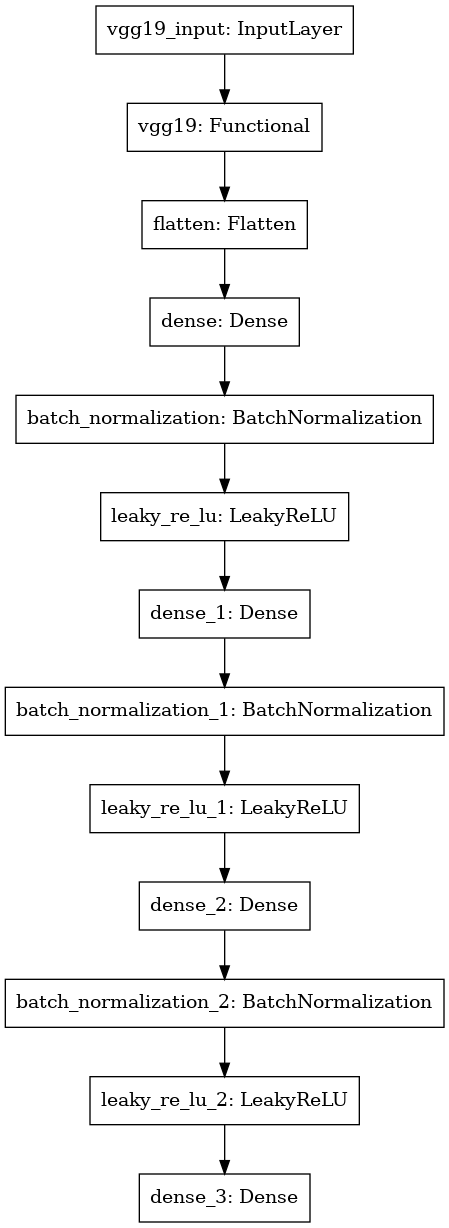

In [55]:
plot_model(model, to_file='vgg19_model.png')


In [56]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)


In [58]:
history = model.fit(x_train,y_train,batch_size=32,epochs=20,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[earlystop,reduce_lr])

Epoch 1/20
94/94 [==============================] - 55s 567ms/step - loss: 0.7859 - accuracy: 0.6071 - val_loss: 0.7195 - val_accuracy: 0.6832
Epoch 2/20
94/94 [==============================] - 53s 562ms/step - loss: 0.4212 - accuracy: 0.8044 - val_loss: 0.5525 - val_accuracy: 0.7580
Epoch 3/20
94/94 [==============================] - 53s 562ms/step - loss: 0.2532 - accuracy: 0.8950 - val_loss: 0.5601 - val_accuracy: 0.7955
Epoch 4/20
94/94 [==============================] - 53s 562ms/step - loss: 0.1522 - accuracy: 0.9421 - val_loss: 0.5952 - val_accuracy: 0.8168
Epoch 5/20
94/94 [==============================] - 53s 561ms/step - loss: 0.1236 - accuracy: 0.9512 - val_loss: 1.0546 - val_accuracy: 0.7166
Epoch 6/20
94/94 [==============================] - 53s 560ms/step - loss: 0.1026 - accuracy: 0.9623 - val_loss: 1.6999 - val_accuracy: 0.7126
Epoch 7/20
94/94 [==============================] - 53s 562ms/step - loss: 0.0906 - accuracy: 0.9655 - val_loss: 0.5979 - val_accuracy: 0.8396

In [59]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

24/24 [==============================] - 11s 429ms/step - loss: 0.5442 - accuracy: 0.8770
loss: 0.54424649477005
Accuracy: 0.8770053386688232


In [60]:
y_pred = model.predict_classes(x_test)
accuracy_score(y_test,y_pred)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.8770053475935828

In [61]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       354
           1       0.88      0.89      0.88       394

    accuracy                           0.88       748
   macro avg       0.88      0.88      0.88       748
weighted avg       0.88      0.88      0.88       748



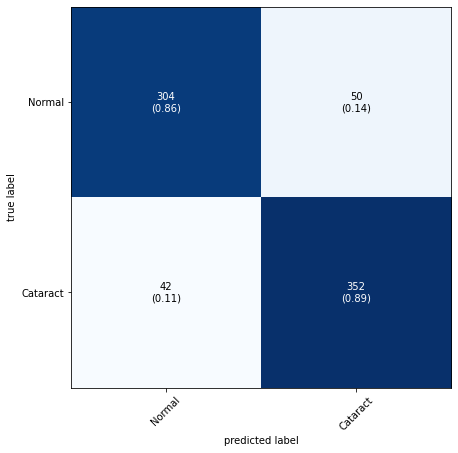

In [62]:
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);
plt.savefig('conv_vgg19.png')


><h3>Learning Curve</h3>

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


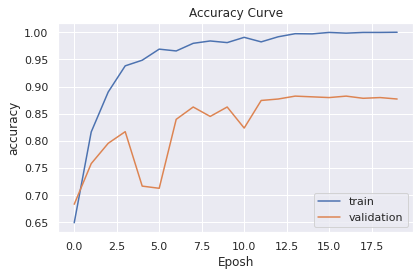

In [63]:
sns.set()
fig = plt.figure(0, (6, 4))

sns.lineplot(history.epoch, history.history['accuracy'], label = 'train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label = 'validation')
  
plt.xlabel('Eposh')
plt.ylabel('accuracy')
plt.title('Accuracy Curve')
plt.tight_layout()

plt.savefig('Accuracy.png')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


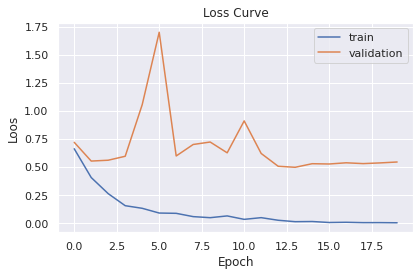

In [64]:

sns.lineplot(history.epoch, history.history['loss'], label = 'train')
sns.lineplot(history.epoch, history.history['val_loss'], label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Loos')
plt.title('Loss Curve')
plt.tight_layout()

plt.savefig('Loss.png')
plt.show()

><h3>Prediction:</h3>

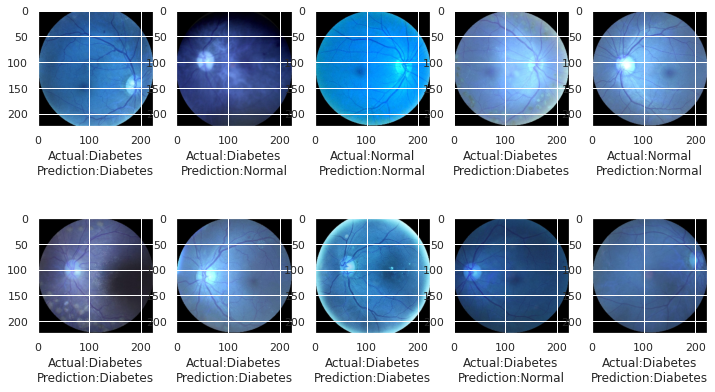

In [66]:
plt.figure(figsize=(12,7))
for i in range(10):
    test = random.choice(range(len(x_test)))
    image = x_test[test]
    category = y_test[test]
    pred_category = y_pred[test]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Diabetes"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Diabetes"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))

    plt.savefig('Test Vgg.png')


In [67]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16 = VGG16(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

58892288/58889256 [==============================] - 1s 0us/step


In [68]:
for layer in vgg16.layers:
    layer.trainable = False

In [83]:

model2 = Sequential()
model2.add(vgg16)
model2.add(Flatten())
model2.add(keras.layers.Dense(1024))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.LeakyReLU())

model2.add(keras.layers.Dense(512))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.LeakyReLU())

model2.add(keras.layers.Dense(256))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.LeakyReLU())
model2.add(Dense(1,activation="sigmoid"))

In [84]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

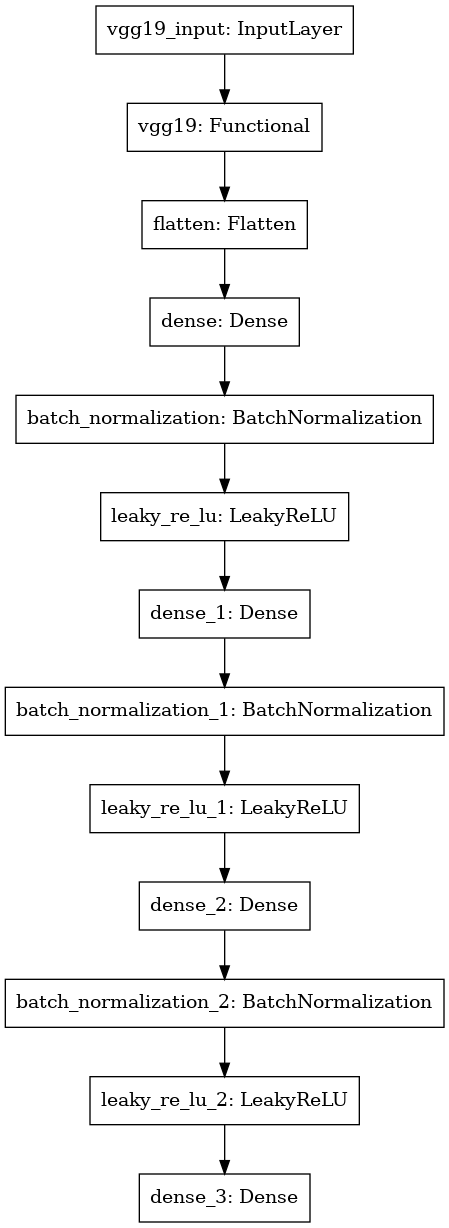

In [85]:
plot_model(model, to_file='vgg16_model.png')


In [86]:
model2.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [87]:
train_model = model2.fit(x_train, y_train,
                  batch_size=32,
                  epochs=20,
                  validation_data=(x_test,y_test),
                    verbose=1,callbacks=[earlystop,reduce_lr])

Epoch 1/20
94/94 [==============================] - 45s 464ms/step - loss: 0.7945 - accuracy: 0.6017 - val_loss: 0.6065 - val_accuracy: 0.7366
Epoch 2/20
94/94 [==============================] - 43s 455ms/step - loss: 0.3759 - accuracy: 0.8351 - val_loss: 0.5932 - val_accuracy: 0.7794
Epoch 3/20
94/94 [==============================] - 43s 456ms/step - loss: 0.2135 - accuracy: 0.9236 - val_loss: 0.6013 - val_accuracy: 0.7981
Epoch 4/20
94/94 [==============================] - 43s 455ms/step - loss: 0.1528 - accuracy: 0.9449 - val_loss: 0.6897 - val_accuracy: 0.7914
Epoch 5/20
94/94 [==============================] - 43s 456ms/step - loss: 0.1468 - accuracy: 0.9403 - val_loss: 0.7807 - val_accuracy: 0.7995
Epoch 6/20
94/94 [==============================] - 43s 457ms/step - loss: 0.1013 - accuracy: 0.9688 - val_loss: 0.6414 - val_accuracy: 0.8262
Epoch 7/20
94/94 [==============================] - 43s 457ms/step - loss: 0.0447 - accuracy: 0.9854 - val_loss: 0.8034 - val_accuracy: 0.8356

In [88]:
loss,accuracy = model2.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

24/24 [==============================] - 9s 349ms/step - loss: 0.7442 - accuracy: 0.8476
loss: 0.7442237138748169
Accuracy: 0.8475936055183411


In [89]:
y_pred2 = model2.predict_classes(x_test)
accuracy_score(y_test,y_pred)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.8770053475935828

In [90]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       354
           1       0.86      0.86      0.86       394

    accuracy                           0.85       748
   macro avg       0.85      0.85      0.85       748
weighted avg       0.85      0.85      0.85       748



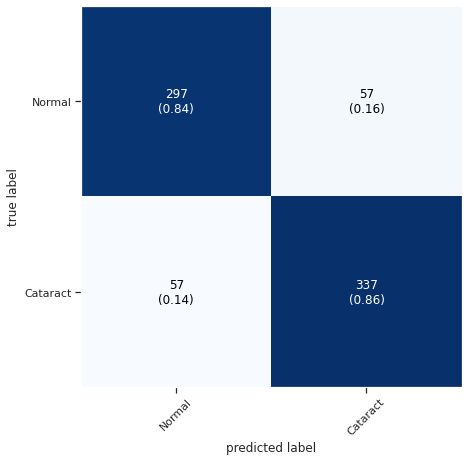

In [91]:
cm = confusion_matrix(y_test,y_pred2)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

plt.savefig('conv_vgg16.png')


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


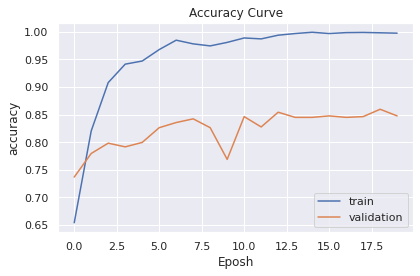

In [92]:
sns.set()
fig = plt.figure(0, (6, 4))

sns.lineplot(train_model.epoch, train_model.history['accuracy'], label = 'train')
sns.lineplot(train_model.epoch, train_model.history['val_accuracy'], label = 'validation')
  
plt.xlabel('Eposh')
plt.ylabel('accuracy')
plt.title('Accuracy Curve')
plt.tight_layout()

plt.savefig('Accuracy2.png')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


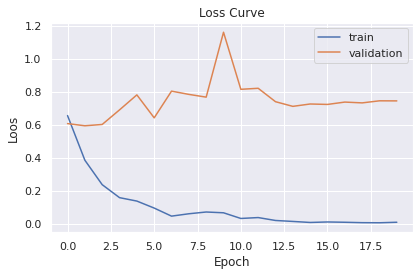

In [93]:

sns.lineplot(train_model.epoch, train_model.history['loss'], label = 'train')
sns.lineplot(train_model.epoch, train_model.history['val_loss'], label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Loos')
plt.title('Loss Curve')
plt.tight_layout()

plt.savefig('Loss2.png')
plt.show()

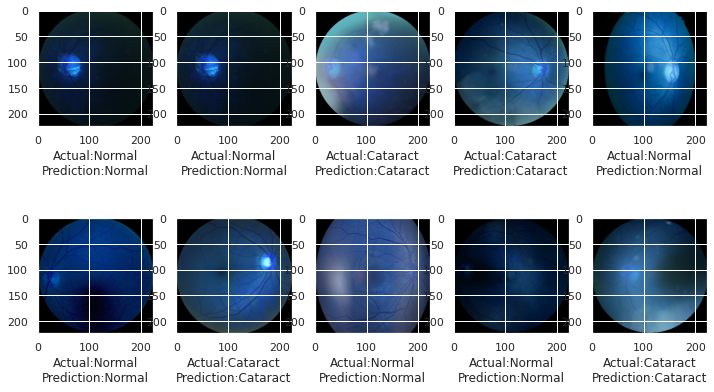

In [94]:
plt.figure(figsize=(12,7))
for i in range(10):
    test = random.choice(range(len(x_test)))
    image = x_test[test]
    category = y_test[test]
    pred_category = y_pred2[test]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))

    plt.savefig('Test Vgg16.png')


In [95]:
import tensorflow as tf

tf.keras.models.save_model(model,'model1.h5')
tf.keras.models.save_model(model2,'model2.h5')